In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()
!pip install openpyxl

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 07:05:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Defaulting to user installation because normal site-packages is not writeable


# BU

business objectives: 

Identify the factors and their degree of relevance to
the average GDP of developing and developed countries, respectively.
Through the comparison, recommendations are made for the economic development of developing and developed countries, respectively.



In [2]:
# 02-DU

import pandas as pd
from pyspark.sql.functions import col, count, isnan, when, mean as _mean, stddev as _stddev

# get data
total_data = 'world-surface.xlsx'
developed_data = 'Developed.xlsx'
developing_data = 'Developing.xlsx'

df_pandas = pd.read_excel(total_data)
df_developed_pandas = pd.read_excel(developed_data)
df_developing_pandas = pd.read_excel(developing_data)

# pre
df_pandas['Country'] = df_pandas['Country'].astype(str)

# convert pandas DataFrame into Spark DataFrame
df_spark = spark.createDataFrame(df_pandas)
df_developed_spark = spark.createDataFrame(df_developed_pandas)
df_developing_spark = spark.createDataFrame(df_developing_pandas)

# explore data
df_spark.printSchema()
df_spark.describe().show()
df_developed_spark.describe().show()
df_developing_spark.describe().show()

# null
null_counts = df_spark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_spark.columns])

# total
total_count = df_spark.count()

# couunt of non-null
non_null_counts = null_counts.select([(total_count - col(c)).alias(c) for c in null_counts.columns])

# type
data_types = df_spark.dtypes

# null count table
summary_table = non_null_counts.toPandas().transpose().reset_index()
summary_table.columns = ['Column', 'Non-Null Count']
null_counts_pd = null_counts.toPandas().transpose().reset_index()
null_counts_pd.columns = ['Column', 'Null Count']
summary_table = summary_table.merge(null_counts_pd, on='Column')
summary_table['Data Type'] = [dtype for _, dtype in data_types]

print(summary_table)

root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Gross primary education enrollment (%): double (nullable = true)
 |-- Gross tertiary education enrollment (%): double (nullable = true)
 |-- Out of pocket health expenditure: double (nullable = true)
 |-- Physicians per thousand: double (nullable = true)
 |-- Density\n(P/Km2): double (nullable = true)
 |-- Fertility Rate: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Urban_population: double (nullable = true)
 |-- Unemployment rate: double (nullable = true)
 |-- Population: Labor force participation (%): double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Tax revenue (%): double (nullable = true)
 |-- Total tax rate: double (nullable = true)



+-------+-----------+-----------+--------------------------------------+---------------------------------------+--------------------------------+-----------------------+----------------+--------------+----------+----------------+-----------------+-----------------------------------------+-----+---------------+--------------+
|summary|    Country|        GDP|Gross primary education enrollment (%)|Gross tertiary education enrollment (%)|Out of pocket health expenditure|Physicians per thousand|Density\n(P/Km2)|Fertility Rate|Population|Urban_population|Unemployment rate|Population: Labor force participation (%)|  CPI|Tax revenue (%)|Total tax rate|
+-------+-----------+-----------+--------------------------------------+---------------------------------------+--------------------------------+-----------------------+----------------+--------------+----------+----------------+-----------------+-----------------------------------------+-----+---------------+--------------+
|  count|        20

                                       Column  Non-Null Count  Null Count  \
0                                     Country             199           1   
1                                         GDP             197           3   
2      Gross primary education enrollment (%)             192           8   
3     Gross tertiary education enrollment (%)             187          13   
4            Out of pocket health expenditure             192           8   
5                     Physicians per thousand             192           8   
6                            Density\n(P/Km2)             199           1   
7                              Fertility Rate             192           8   
8                                  Population             198           2   
9                            Urban_population             194           6   
10                          Unemployment rate             180          20   
11  Population: Labor force participation (%)             180          20   

In [3]:
from pyspark.sql.functions import col, count, isnan, when, mean as _mean, stddev as _stddev, expr
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

def audit_data(df_spark):
    # create a list to store results
    result = []
    columns = df_spark.columns

    # check each column
    for column in columns:
        if df_spark.schema[column].dataType in [pyspark.sql.types.IntegerType(), pyspark.sql.types.FloatType(), pyspark.sql.types.DoubleType()]:
            # get Extremes
            q95 = df_spark.approxQuantile(column, [0.95], 0.01)[0]
            q05 = df_spark.approxQuantile(column, [0.05], 0.01)[0]
            extreme_value = float(df_spark.filter((col(column) > q95) | (col(column) < q05)).count())
            
            filtered_df = df_spark.filter(col(column).isNotNull() & ~isnan(col(column)))
            
            # get Outliers
            mean_val = filtered_df.select(_mean(col(column))).collect()[0][0]
            std_val = filtered_df.select(_stddev(col(column))).collect()[0][0]
            if mean_val is None or std_val is None:
                mean_val = float('nan')
                std_val = float('nan')
            else:
                outlier = float(filtered_df.filter((col(column) > mean_val + 3 * std_val) | (col(column) < mean_val - 3 * std_val)).count())
            
        else:
            extreme_value = float('nan')
            outlier = float('nan')

        # get null
        null_value = float(df_spark.filter(col(column).isNull() | isnan(col(column))).count())

        # get empty-string/ white_space
        if df_spark.schema[column].dataType == pyspark.sql.types.StringType():
            empty_string = float(df_spark.filter(col(column) == '').count())
            white_space = float(df_spark.filter(col(column) == ' ').count())
        else:
            empty_string = float('nan')
            white_space = float('nan')

        # add result to list
        result.append([column, extreme_value, outlier, null_value, empty_string, white_space])

    # define schema
    schema = StructType([
        StructField("Field", StringType(), True),
        StructField("Extreme Value", DoubleType(), True),
        StructField("Outlier", DoubleType(), True),
        StructField("Null Value", DoubleType(), True),
        StructField("Empty String", DoubleType(), True),
        StructField("White Space", DoubleType(), True)
    ])

    # convet into Spark DataFrame
    result_df = spark.createDataFrame(result, schema=schema)
    
    return result_df

# Autia data
audit_result = audit_data(df_spark)
audit_result.show(truncate=False)

+-----------------------------------------+-------------+-------+----------+------------+-----------+
|Field                                    |Extreme Value|Outlier|Null Value|Empty String|White Space|
+-----------------------------------------+-------------+-------+----------+------------+-----------+
|Country                                  |NaN          |NaN    |1.0       |0.0         |0.0        |
|GDP                                      |21.0         |3.0    |3.0       |NaN         |NaN        |
|Gross primary education enrollment (%)   |27.0         |3.0    |8.0       |NaN         |NaN        |
|Gross tertiary education enrollment (%)  |32.0         |2.0    |13.0      |NaN         |NaN        |
|Out of pocket health expenditure         |27.0         |4.0    |8.0       |NaN         |NaN        |
|Physicians per thousand                  |26.0         |2.0    |8.0       |NaN         |NaN        |
|Density\n(P/Km2)                         |17.0         |2.0    |1.0       |NaN   

In [4]:
from pyspark.sql.functions import min as _min, max as _max

def summary_statistics(df_spark):
    # create a list to store results
    result = []
    columns = df_spark.columns

    # check each column
    for column in columns:
        if df_spark.schema[column].dataType in [pyspark.sql.types.IntegerType(), pyspark.sql.types.FloatType(), pyspark.sql.types.DoubleType()]:
            # filter null
            filtered_df = df_spark.filter(col(column).isNotNull() & ~isnan(col(column)))

            # get statistic value
            mean_val = filtered_df.select(_mean(col(column))).collect()[0][0]
            median_val = filtered_df.approxQuantile(column, [0.5], 0.01)[0]
            min_val = filtered_df.select(_min(col(column))).collect()[0][0]
            max_val = filtered_df.select(_max(col(column))).collect()[0][0]
            std_val = filtered_df.select(_stddev(col(column))).collect()[0][0]

            # add results to list
            result.append([column, mean_val, median_val, min_val, max_val, std_val])
        else:
            result.append([column, float('nan'), float('nan'), float('nan'), float('nan'), float('nan')])

    # define schema
    schema = StructType([
        StructField("Field", StringType(), True),
        StructField("Mean", DoubleType(), True),
        StructField("Median", DoubleType(), True),
        StructField("Min", DoubleType(), True),
        StructField("Max", DoubleType(), True),
        StructField("StdDev", DoubleType(), True)
    ])

    # conver into schema
    result_df = spark.createDataFrame(result, schema=schema)

    return result_df

summary_result = summary_statistics(df_spark)
summary_result.show(truncate=False)

+-----------------------------------------+--------------------+------------------+-------------------+------------+---------------------+
|Field                                    |Mean                |Median            |Min                |Max         |StdDev               |
+-----------------------------------------+--------------------+------------------+-------------------+------------+---------------------+
|Country                                  |NaN                 |NaN               |NaN                |NaN         |NaN                  |
|GDP                                      |5.900459418297521E11|3.6266259213E10   |4.7271463E7        |2.14277E13  |2.6199992348352197E12|
|Gross primary education enrollment (%)   |1.017793235936147   |1.0244705882352938|0.13183071150490314|1.425       |0.15862745165788114  |
|Gross tertiary education enrollment (%)  |0.3834188727965039  |0.3125            |0.008              |1.366       |0.2991298339384076   |
|Out of pocket health expen

Defaulting to user installation because normal site-packages is not writeable


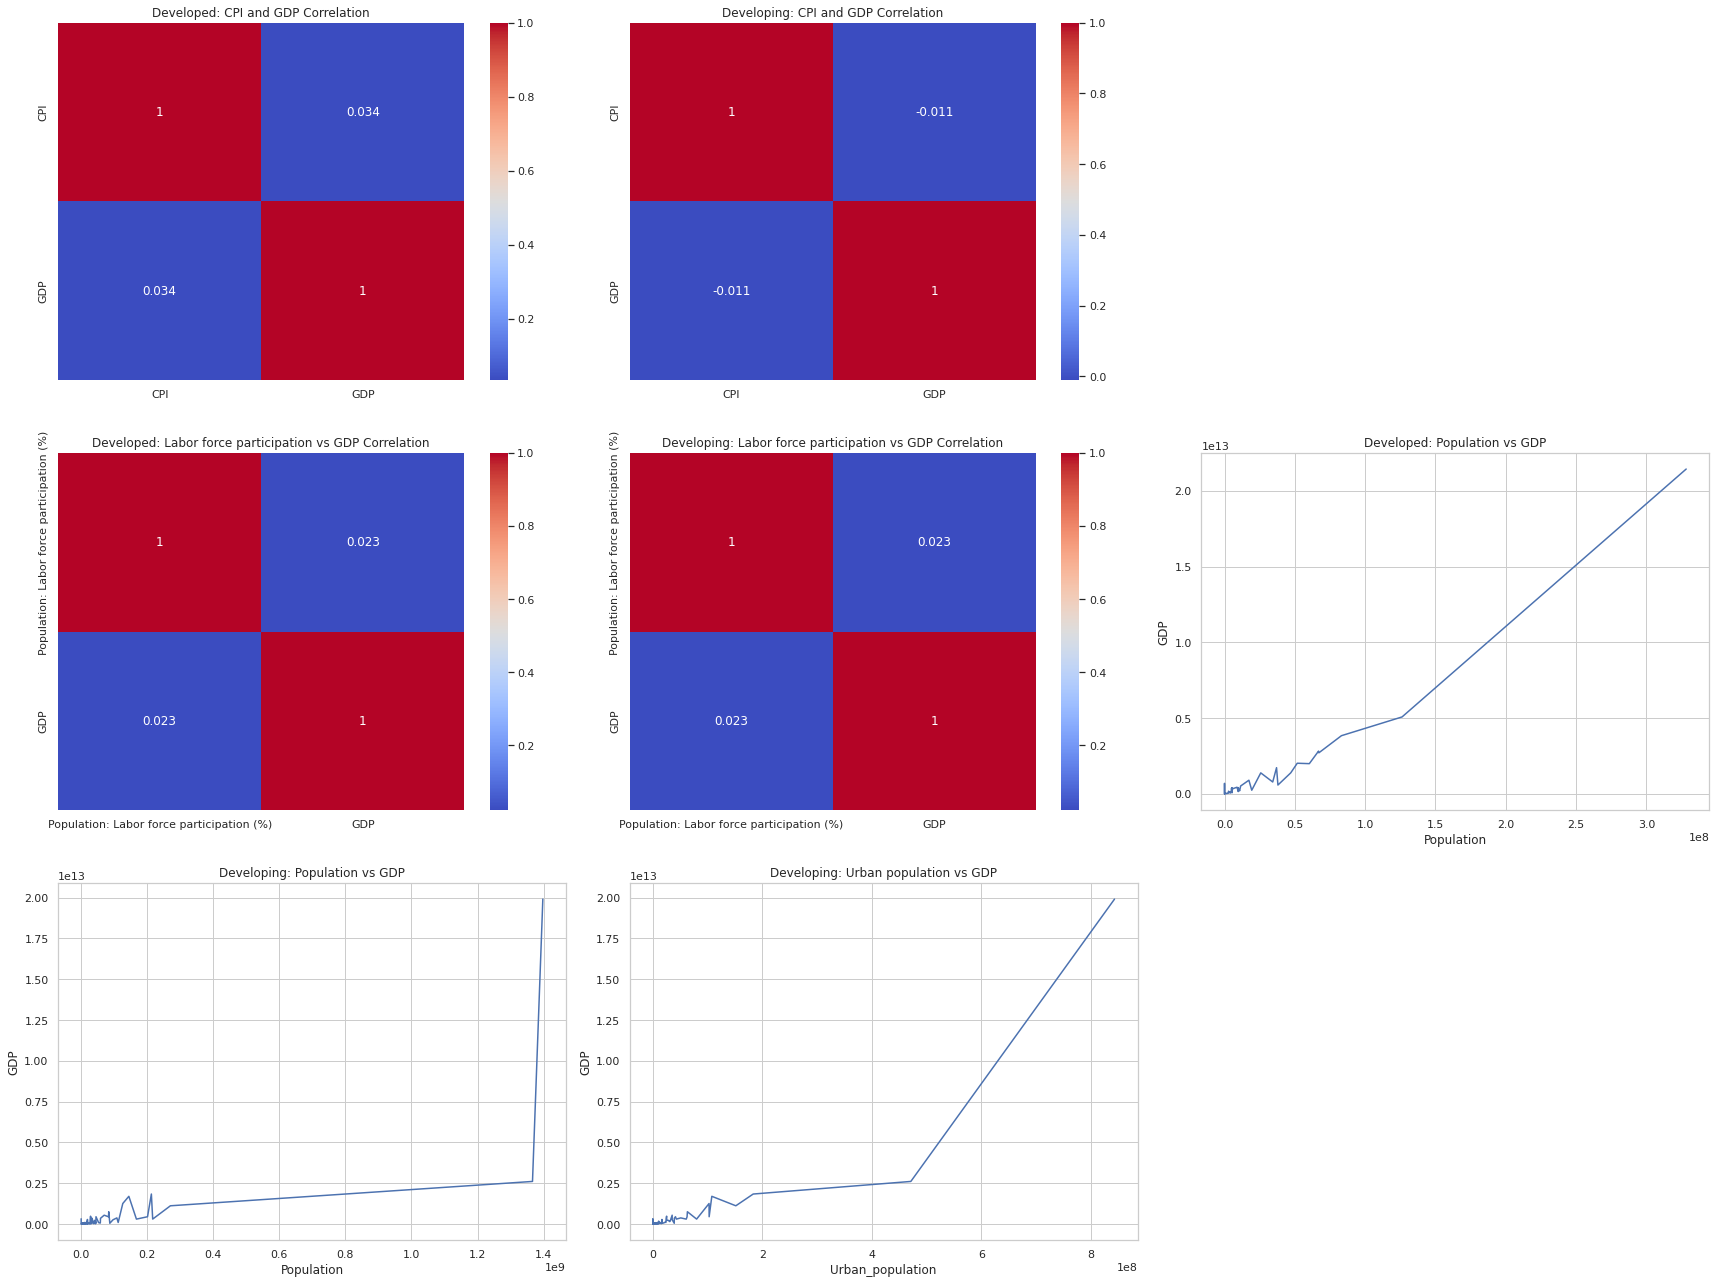

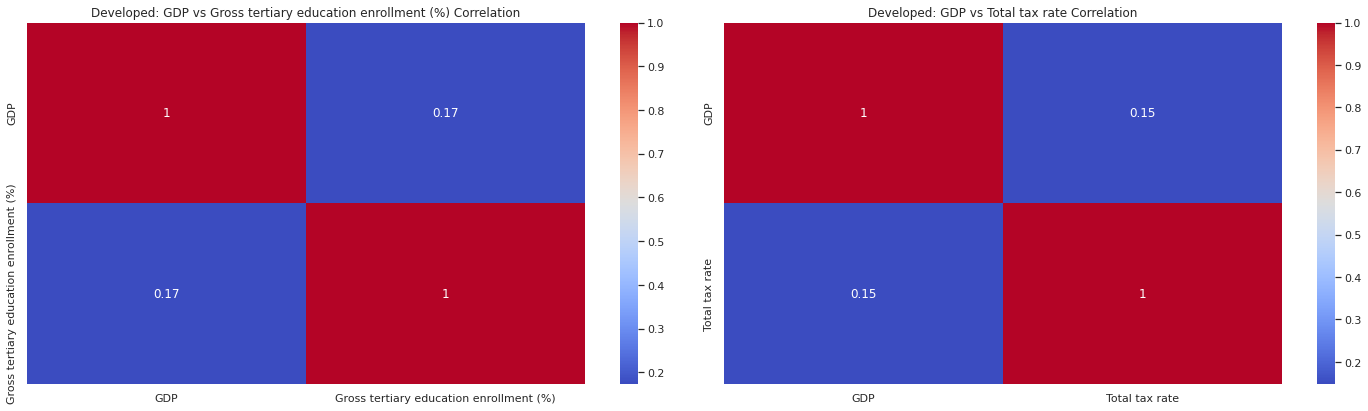

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
!pip install matplotlib seaborn

# convert PySpark DataFrame into Pandas DataFrame
df_developed_pandas = df_developed_spark.toPandas()
df_developing_pandas = df_developing_spark.toPandas()

# get plot
def plot_graphs(df_developed, df_developing):
    plt.figure(figsize=(24, 18))
    
    # Correlation Heatmap for Developed
    plt.subplot(3, 3, 1)
    corr_developed = df_developed[['CPI', 'GDP']].corr()
    sns.heatmap(corr_developed, annot=True, cmap='coolwarm')
    plt.title('Developed: CPI and GDP Correlation')
    
    # Correlation Heatmap for Developing
    plt.subplot(3, 3, 2)
    corr_developing = df_developing[['CPI', 'GDP']].corr()
    sns.heatmap(corr_developing, annot=True, cmap='coolwarm')
    plt.title('Developing: CPI and GDP Correlation')
    
    # Correlation Heatmap for Population: Labor force participation (%) vs GDP (Developed)
    plt.subplot(3, 3, 4)
    corr_developed_labor = df_developed[['Population: Labor force participation (%)', 'GDP']].corr()
    sns.heatmap(corr_developed_labor, annot=True, cmap='coolwarm')
    plt.title('Developed: Labor force participation vs GDP Correlation')
    
    # Correlation Heatmap for Population: Labor force participation (%) vs GDP (Developing)
    plt.subplot(3, 3, 5)
    corr_developing_labor = df_developing[['Population: Labor force participation (%)', 'GDP']].corr()
    sns.heatmap(corr_developing_labor, annot=True, cmap='coolwarm')
    plt.title('Developing: Labor force participation vs GDP Correlation')
    
    # Line plot for Population vs GDP (Developed)
    plt.subplot(3, 3, 6)
    sns.lineplot(data=df_developed, x='Population', y='GDP')
    plt.title('Developed: Population vs GDP')

    # Line plot for Population vs GDP (Developing)
    plt.subplot(3, 3, 7)
    sns.lineplot(data=df_developing, x='Population', y='GDP')
    plt.title('Developing: Population vs GDP')
    
    # Line plot for Urban_population vs GDP (Developing)
    plt.subplot(3, 3, 8)
    sns.lineplot(data=df_developing, x='Urban_population', y='GDP')
    plt.title('Developing: Urban population vs GDP')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(20, 6))
    
    # Correlation Heatmap for GDP vs Gross tertiary education enrollment (%) (Developed)
    plt.subplot(1, 2, 1)
    corr_developed_education = df_developed[['GDP', 'Gross tertiary education enrollment (%)']].corr()
    sns.heatmap(corr_developed_education, annot=True, cmap='coolwarm')
    plt.title('Developed: GDP vs Gross tertiary education enrollment (%) Correlation')
    
    # Correlation Heatmap for GDP vs Total tax rate (Developed)
    plt.subplot(1, 2, 2)
    corr_developed_tax = df_developed[['GDP', 'Total tax rate']].corr()
    sns.heatmap(corr_developed_tax, annot=True, cmap='coolwarm')
    plt.title('Developed: GDP vs Total tax rate Correlation')
    
    plt.tight_layout()
    plt.show()

plot_graphs(df_developed_pandas, df_developing_pandas)

In [6]:
# 03-DP

# delete columns we don't need
columns_to_drop = ['Gross primary education enrollment (%)', 'Out of pocket health expenditure', 
                   'Density\n(P/Km2)', 'Fertility Rate', 'Unemployment rate', 'Tax revenue (%)', 
                   'Total tax rate']

df_developed_spark = df_developed_spark.drop(*columns_to_drop)
df_developing_spark = df_developing_spark.drop(*columns_to_drop)

print("Schema for developed countries data:")
df_developed_spark.printSchema()

print("Schema for developing countries data:")
df_developing_spark.printSchema()


Schema for developed countries data:
root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Gross tertiary education enrollment (%): double (nullable = true)
 |-- Physicians per thousand: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Urban_population: double (nullable = true)
 |-- Population: Labor force participation (%): double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Is_Developed: long (nullable = true)

Schema for developing countries data:
root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Gross tertiary education enrollment (%): double (nullable = true)
 |-- Physicians per thousand: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Urban_population: double (nullable = true)
 |-- Population: Labor force participation (%): double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Is_Developed: long (nullable = true)



In [7]:
# Audit developed data and developing data respectively

print("Audit for developed countries data:")
audit_developed_result = audit_data(df_developed_spark)
audit_developed_result.show(truncate=False)

print("Audit for developing countries data:")
audit_developing_result = audit_data(df_developing_spark)
audit_developing_result.show(truncate=False)

Audit for developed countries data:
+-----------------------------------------+-------------+-------+----------+------------+-----------+
|Field                                    |Extreme Value|Outlier|Null Value|Empty String|White Space|
+-----------------------------------------+-------------+-------+----------+------------+-----------+
|Country                                  |NaN          |NaN    |0.0       |0.0         |0.0        |
|GDP                                      |5.0          |1.0    |1.0       |NaN         |NaN        |
|Gross tertiary education enrollment (%)  |7.0          |1.0    |3.0       |NaN         |NaN        |
|Physicians per thousand                  |6.0          |2.0    |2.0       |NaN         |NaN        |
|Population                               |4.0          |1.0    |0.0       |NaN         |NaN        |
|Urban_population                         |5.0          |1.0    |1.0       |NaN         |NaN        |
|Population: Labor force participation (%)|9.0

In [8]:
from pyspark.sql.functions import lit

def replace_null_with_midrange(df_spark):
    # get numeric column
    numeric_columns = [column for column, dtype in df_spark.dtypes if dtype in ('int', 'double')]
    
    for column in numeric_columns:
        # get median
        median_value = df_spark.approxQuantile(column, [0.5], 0.01)[0]
        # replace null-value with median
        df_spark = df_spark.withColumn(column, when(col(column).isNull() | isnan(col(column)), lit(median_value)).otherwise(col(column)))
    
    return df_spark

# replace
df_promissing_developed_spark = replace_null_with_midrange(df_developed_spark)
df_promissing_developing_spark = replace_null_with_midrange(df_developing_spark)

# Audit again
audit_result_developed = audit_data(df_promissing_developed_spark)
audit_result_developing = audit_data(df_promissing_developing_spark)

# show result of Audit
print("Audit for developed countries data:")
audit_result_developed.show(truncate=False)

print("Audit for developing countries data:")
audit_result_developing.show(truncate=False)

Audit for developed countries data:
+-----------------------------------------+-------------+-------+----------+------------+-----------+
|Field                                    |Extreme Value|Outlier|Null Value|Empty String|White Space|
+-----------------------------------------+-------------+-------+----------+------------+-----------+
|Country                                  |NaN          |NaN    |0.0       |0.0         |0.0        |
|GDP                                      |4.0          |1.0    |0.0       |NaN         |NaN        |
|Gross tertiary education enrollment (%)  |4.0          |1.0    |0.0       |NaN         |NaN        |
|Physicians per thousand                  |4.0          |2.0    |0.0       |NaN         |NaN        |
|Population                               |4.0          |1.0    |0.0       |NaN         |NaN        |
|Urban_population                         |4.0          |1.0    |0.0       |NaN         |NaN        |
|Population: Labor force participation (%)|4.0

In [9]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, DoubleType

df_developed_spark = df_developed_spark.withColumn('Gross tertiary education enrollment (%)', F.col('Gross tertiary education enrollment (%)').cast(StringType()))
df_developed_spark = df_developed_spark.withColumn('Population: Labor force participation (%)', F.col('Population: Labor force participation (%)').cast(StringType()))

print("Schema before converting to DoubleType:")
df_developed_spark.printSchema()

df_developed_spark = df_developed_spark.withColumn('Gross tertiary education enrollment (%)', F.col('Gross tertiary education enrollment (%)').cast(DoubleType()))
df_developed_spark = df_developed_spark.withColumn('Population: Labor force participation (%)', F.col('Population: Labor force participation (%)').cast(DoubleType()))

print("Schema after converting to DoubleType:")
df_developed_spark.printSchema()

Schema before converting to DoubleType:
root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Gross tertiary education enrollment (%): string (nullable = true)
 |-- Physicians per thousand: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Urban_population: double (nullable = true)
 |-- Population: Labor force participation (%): string (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Is_Developed: long (nullable = true)

Schema after converting to DoubleType:
root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Gross tertiary education enrollment (%): double (nullable = true)
 |-- Physicians per thousand: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Urban_population: double (nullable = true)
 |-- Population: Labor force participation (%): double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Is_Developed: long (nullable = true)



In [10]:
def coerce_outliers_and_discard_extremes(df_spark):
    # get numeric column
    numeric_columns = [column for column, dtype in df_spark.dtypes if dtype in ('int', 'double')]

    for column in numeric_columns:
        # get median
        median_value = df_spark.approxQuantile(column, [0.5], 0.01)[0]
        
        # get mean and std
        mean_val = df_spark.select(_mean(col(column))).collect()[0][0]
        std_val = df_spark.select(_stddev(col(column))).collect()[0][0]
        
        # define outlier
        lower_bound = mean_val - 3 * std_val
        upper_bound = mean_val + 3 * std_val
        
        # replace outlier with median
        df_spark = df_spark.withColumn(column, when((col(column) < lower_bound) | (col(column) > upper_bound), median_value).otherwise(col(column)))
        
        q1 = df_spark.approxQuantile(column, [0.25], 0.01)[0]
        q3 = df_spark.approxQuantile(column, [0.75], 0.01)[0]
        iqr = q3 - q1
        
        # define extreme
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr
        
        # delete extreme
        df_spark = df_spark.filter((col(column) >= lower_limit) & (col(column) <= upper_limit))

    return df_spark

# replace outlier with median and delete extreme
df_OE_developed_spark = coerce_outliers_and_discard_extremes(df_promissing_developed_spark)
df_OE_developing_spark = coerce_outliers_and_discard_extremes(df_promissing_developing_spark)

# Audit data
OE_developed = audit_data(df_OE_developed_spark)
OE_developing = audit_data(df_OE_developing_spark)

# show result
print("Audit for developed countries data:")
OE_developed.show(truncate=False)

print("Audit for developing countries data:")
OE_developing.show(truncate=False)

Audit for developed countries data:
+-----------------------------------------+-------------+-------+----------+------------+-----------+
|Field                                    |Extreme Value|Outlier|Null Value|Empty String|White Space|
+-----------------------------------------+-------------+-------+----------+------------+-----------+
|Country                                  |NaN          |NaN    |0.0       |0.0         |0.0        |
|GDP                                      |2.0          |0.0    |0.0       |NaN         |NaN        |
|Gross tertiary education enrollment (%)  |1.0          |0.0    |0.0       |NaN         |NaN        |
|Physicians per thousand                  |2.0          |0.0    |0.0       |NaN         |NaN        |
|Population                               |2.0          |0.0    |0.0       |NaN         |NaN        |
|Urban_population                         |2.0          |0.0    |0.0       |NaN         |NaN        |
|Population: Labor force participation (%)|2.0

Schema for processed developed countries data:
root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Gross tertiary education enrollment (%): double (nullable = true)
 |-- Physicians per thousand: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Urban_population: double (nullable = true)
 |-- Population: Labor force participation (%): double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Is_Developed: long (nullable = true)
 |-- Physicians in Rural: double (nullable = true)

Schema for processed developing countries data:
root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Gross tertiary education enrollment (%): double (nullable = true)
 |-- Physicians per thousand: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Urban_population: double (nullable = true)
 |-- Population: Labor force participation (%): double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- 

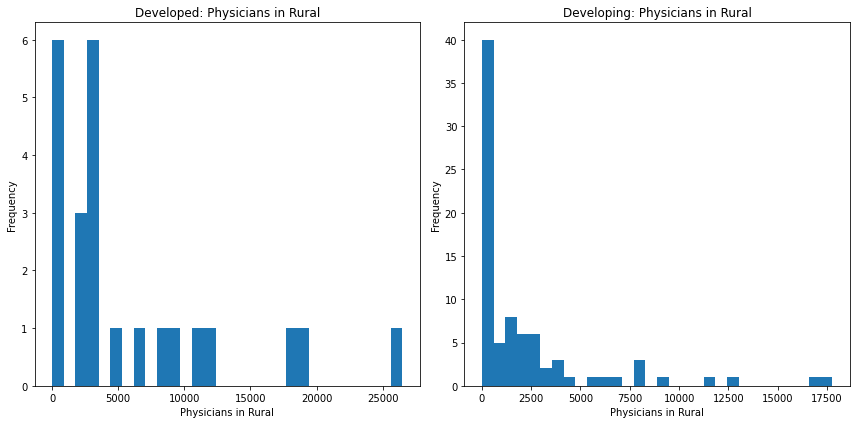

In [11]:
# create new column - Physicians in Rural
df_OE_developed_spark = df_OE_developed_spark.withColumn(
    'Physicians in Rural', 
    ((col('Population') - col('Urban_population')) / 1000) * col('Physicians per thousand')
)

df_OE_developing_spark = df_OE_developing_spark.withColumn(
    'Physicians in Rural', 
    ((col('Population') - col('Urban_population')) / 1000) * col('Physicians per thousand')
)

# filter 'Physicians in Rural' < 0
df_processed_developed_spark = df_OE_developed_spark.filter(col('Physicians in Rural') >= 0)
df_processed_developing_spark = df_OE_developing_spark.filter(col('Physicians in Rural') >= 0)

# show schema
print("Schema for processed developed countries data:")
df_processed_developed_spark.printSchema()

print("Schema for processed developing countries data:")
df_processed_developing_spark.printSchema()

# convert PySpark DataFrame into Pandas DataFrame
df_processed_developed_pandas = df_processed_developed_spark.toPandas()
df_processed_developing_pandas = df_processed_developing_spark.toPandas()

# get the plots about 'Physicians in Rural'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df_processed_developed_pandas['Physicians in Rural'].plot.hist(title='Developed: Physicians in Rural', bins=30)
plt.xlabel('Physicians in Rural')

plt.subplot(1, 2, 2)
df_processed_developing_pandas['Physicians in Rural'].plot.hist(title='Developing: Physicians in Rural', bins=30)
plt.xlabel('Physicians in Rural')

plt.tight_layout()
plt.show()

In [12]:
# get number of rows about developed and developing respectively
num_rows1 = df_processed_developed_spark.count()
num_rows2 = df_processed_developing_spark.count()

# combine DataFrame
combined_df_spark = df_processed_developed_spark.union(df_processed_developing_spark)

# get number of rows after combining
num_rows = combined_df_spark.count()

print(f"Number of rows in processed developed countries data: {num_rows1}")
print(f"Number of rows in processed developing countries data: {num_rows2}")
print(f"Total number of rows after combining: {num_rows}")

Number of rows in processed developed countries data: 24
Number of rows in processed developing countries data: 82
Total number of rows after combining: 106


In [13]:
# get new dataset by pd
add_data = 'Agriculture-land-world-data.xlsx'
df_adddata_pd = pd.read_excel(add_data)

# convert Pandas DataFrame into Spark DataFrame
df_adddata_spark = spark.createDataFrame(df_adddata_pd)

# check out schema
print("Schema for additional data:")
df_adddata_spark.printSchema()
print("Audit for additional data:")
audit_adddate_result = audit_data(df_adddata_spark)
audit_adddate_result.show(truncate=False)

# get columns in total before merging
num_columns_combined = len(combined_df_spark.columns)
print(f"Num of columns in total before merging: {num_columns_combined}")

# connect original dataset and add data.
combined_df_spark = combined_df_spark.join(df_adddata_spark, on='Country', how='left')

# filter data
combined_df_spark = combined_df_spark.filter(col('Agricultural Land( %)') >= 0)

# get median in Agricultural Land( %)
median_value = combined_df_spark.approxQuantile("Agricultural Land( %)", [0.5], 0.01)[0]

# replace null with median
combined_df_spark = combined_df_spark.fillna({'Agricultural Land( %)': median_value})

# check out schema after merging
print("Schema after merging:")
combined_df_spark.printSchema()

# get columns in total after merging
num_columns_combined = len(combined_df_spark.columns)
print(f"Num of columns in total after merging: {num_columns_combined}")

Schema for additional data:
root
 |-- Country: string (nullable = true)
 |-- Agricultural Land( %): double (nullable = true)

Audit for additional data:
+---------------------+-------------+-------+----------+------------+-----------+
|Field                |Extreme Value|Outlier|Null Value|Empty String|White Space|
+---------------------+-------------+-------+----------+------------+-----------+
|Country              |NaN          |NaN    |0.0       |0.0         |0.0        |
|Agricultural Land( %)|25.0         |0.0    |7.0       |NaN         |NaN        |
+---------------------+-------------+-------+----------+------------+-----------+

Num of columns in total before merging: 10
Schema after merging:
root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Gross tertiary education enrollment (%): double (nullable = true)
 |-- Physicians per thousand: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Urban_population: double (nullable = 

In [14]:
from pyspark.sql.functions import round as _round

# sorted by GDP in desc
sorted_df_spark = combined_df_spark.orderBy(col("GDP").desc())

# round dataset
sorted_df_spark = sorted_df_spark.withColumn("GDP", _round(col("GDP"), 1))
sorted_df_spark = sorted_df_spark.withColumn("Gross tertiary education enrollment (%)", _round(col("Gross tertiary education enrollment (%)"), 3))
sorted_df_spark = sorted_df_spark.withColumn("Physicians per thousand", _round(col("Physicians per thousand"), 2))
sorted_df_spark = sorted_df_spark.withColumn("Population", _round(col("Population"), 0))
sorted_df_spark = sorted_df_spark.withColumn("Urban_population", _round(col("Urban_population"), 0))
sorted_df_spark = sorted_df_spark.withColumn("Population: Labor force participation (%)", _round(col("Population: Labor force participation (%)"), 3))
sorted_df_spark = sorted_df_spark.withColumn("CPI", _round(col("CPI"), 1))
sorted_df_spark = sorted_df_spark.withColumn("Physicians in Rural", _round(col("Physicians in Rural"), 0))
sorted_df_spark = sorted_df_spark.withColumn("Agricultural Land( %)", _round(col("Agricultural Land( %)"), 3))

# check out schema
print("Schema after formatting:")
sorted_df_spark.printSchema()

# give example to verify effict
sorted_df_spark.show(5)

Schema after formatting:
root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Gross tertiary education enrollment (%): double (nullable = true)
 |-- Physicians per thousand: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Urban_population: double (nullable = true)
 |-- Population: Labor force participation (%): double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Is_Developed: long (nullable = true)
 |-- Physicians in Rural: double (nullable = true)
 |-- Agricultural Land( %): double (nullable = true)

+-------------------+----------------+---------------------------------------+-----------------------+-----------+----------------+-----------------------------------------+-----+------------+-------------------+---------------------+
|            Country|             GDP|Gross tertiary education enrollment (%)|Physicians per thousand| Population|Urban_population|Population: Labor force participation (%)|  CPI|Is_Develope

In [15]:
# 04-DT

from pyspark.sql.functions import log10

# Filter GDP columns greater than or equal to 0
sorted_df_spark = sorted_df_spark.filter(col('GDP') >= 0)

# Filter rows in the CPI column greater than or equal to 0
sorted_df_spark = sorted_df_spark.filter(col('CPI') >= 0)

# Define functions that take logarithms
def take_log(df_spark):
    log_columns = ['Urban_population', 'Population: Labor force participation (%)', 
                   'Physicians in Rural', 'Population']
    
    log_df_spark = df_spark
    for col_name in log_columns:
        log_df_spark = log_df_spark.withColumn(col_name, log10(col(col_name)))
    
    return log_df_spark

# Logarithmic operations on specified columns
log_sorted_df_spark = take_log(sorted_df_spark)

# Viewing the schema of a DataFrame
print("Schema after log transformation:")
log_sorted_df_spark.printSchema()

# Display the results
log_sorted_df_spark.show(5)


Schema after log transformation:
root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Gross tertiary education enrollment (%): double (nullable = true)
 |-- Physicians per thousand: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Urban_population: double (nullable = true)
 |-- Population: Labor force participation (%): double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Is_Developed: long (nullable = true)
 |-- Physicians in Rural: double (nullable = true)
 |-- Agricultural Land( %): double (nullable = true)

+-------------------+----------------+---------------------------------------+-----------------------+------------------+-----------------+-----------------------------------------+-----+------------+-------------------+---------------------+
|            Country|             GDP|Gross tertiary education enrollment (%)|Physicians per thousand|        Population| Urban_population|Population: Labor force participati

In [16]:
sorted_df_spark = sorted_df_spark.filter(col('GDP') >= 0)
sorted_df_spark = sorted_df_spark.filter(col('CPI') >= 0)

def take_log(df_spark):
    log_columns = ['Urban_population', 'Population: Labor force participation (%)', 
                   'Physicians in Rural', 'Population']
    
    log_df_spark = df_spark
    for col_name in log_columns:
        log_df_spark = log_df_spark.withColumn(col_name, log10(col(col_name)))
    
    return log_df_spark

log_sorted_df_spark = take_log(sorted_df_spark)

print("Schema after log transformation:")
log_sorted_df_spark.printSchema()

log_sorted_df_spark.show(5)


Schema after log transformation:
root
 |-- Country: string (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Gross tertiary education enrollment (%): double (nullable = true)
 |-- Physicians per thousand: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Urban_population: double (nullable = true)
 |-- Population: Labor force participation (%): double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Is_Developed: long (nullable = true)
 |-- Physicians in Rural: double (nullable = true)
 |-- Agricultural Land( %): double (nullable = true)

+-------------------+----------------+---------------------------------------+-----------------------+------------------+-----------------+-----------------------------------------+-----+------------+-------------------+---------------------+
|            Country|             GDP|Gross tertiary education enrollment (%)|Physicians per thousand|        Population| Urban_population|Population: Labor force participati

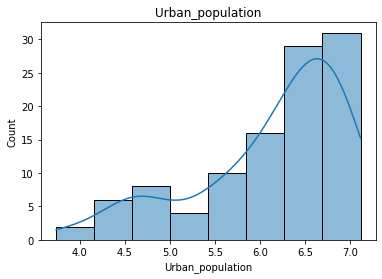

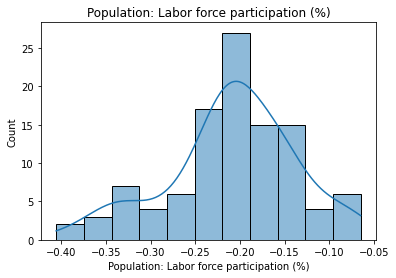

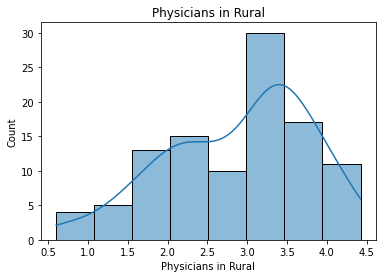

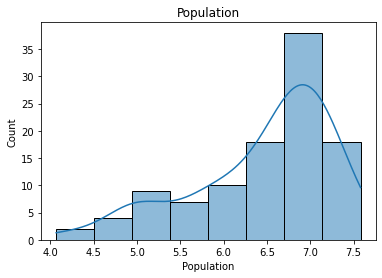

In [17]:
# convert PySpark DataFrame into Pandas DataFrame
log_sorted_df_pandas = log_sorted_df_spark.toPandas()

cols = ['Urban_population', 'Population: Labor force participation (%)', 
        'Physicians in Rural', 'Population']

# get histogram
for col in cols:
    sns.histplot(log_sorted_df_pandas[col].dropna(), kde=True)
    plt.title(col)
    plt.show()

# 05-DMM

 I will use regression analysis, cluster analysis, and decision tree as my DM methods for analysis.


In [18]:
# 06-DMA
# 07-DM
from pyspark.sql.functions import col
developed_df_spark = sorted_df_spark.filter(col('Is_Developed') == 1)
developing_df_spark = sorted_df_spark.filter(col('Is_Developed') == 0)

# Regression Algorithm
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import abs as _abs

def regression_algorithm(df_spark):
    features = df_spark.columns
    features.remove("Country")
    features.remove("Is_Developed")
    features.remove("GDP")
    
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    df_spark = assembler.transform(df_spark)
    
    # Standardize features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
    scaler_model = scaler.fit(df_spark)
    df_spark = scaler_model.transform(df_spark)
    
    # Modeling regression
    lr = LinearRegression(featuresCol="scaledFeatures", labelCol="GDP")
    lr_model = lr.fit(df_spark)
    
    # Obtaining standardized coefficients
    coef_df = pd.DataFrame({'Feature': features, 'Coefficient': lr_model.coefficients})
    
    # Sorting coefficients by absolute value
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].apply(lambda x: abs(float(x)))
    coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
    
    # Print the sorted coefficients
    print("Feature Importances:")
    for index, row in coef_df.iterrows():
        print(f"{row['Feature']}: {row['Coefficient']}")
    
    # R-square
    r_squared = lr_model.summary.r2
    print(f"\nR² Score: {r_squared}")
    
    # carry out forecasting
    predictions = lr_model.transform(df_spark)
   
    # Calculate the mean square error
    evaluator = RegressionEvaluator(labelCol="GDP", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)
    print(f"Mean Squared Error (MSE): {mse}")
    
    print('--------------------------------------------------')

# Implementation of the regression algorithm
print("developed dataset:")
regression_algorithm(developed_df_spark)
print("developing dataset:")
regression_algorithm(developing_df_spark)


developed dataset:


24/05/21 04:45:46 WARN Instrumentation: [32e4bf4e] regParam is zero, which might cause numerical instability and overfitting.
24/05/21 04:45:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/21 04:45:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
24/05/21 04:45:46 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Feature Importances:
Urban_population: 389681855810.9679
Population: -365433031776.72235
Physicians in Rural: 150045204261.8571
Physicians per thousand: -47127193381.58099
Population: Labor force participation (%): 40440491434.02842
Gross tertiary education enrollment (%): 36265126386.45893
Agricultural Land( %): 8766223291.010317
CPI: -7919548665.39927

R² Score: 0.7387902649707829
Mean Squared Error (MSE): 6.313558523007745e+21
--------------------------------------------------
developing dataset:


24/05/21 04:45:51 WARN Instrumentation: [95bd4de4] regParam is zero, which might cause numerical instability and overfitting.


Feature Importances:
Urban_population: 19443366998.491146
Population: -9386225254.910862
Physicians in Rural: 9006099688.970045
Gross tertiary education enrollment (%): 5099189782.435342
CPI: -2170058238.312573
Agricultural Land( %): -1935752663.493493
Population: Labor force participation (%): 1832752112.2278516
Physicians per thousand: -47117370.82132359

R² Score: 0.6732141113156105
Mean Squared Error (MSE): 1.6736585031159946e+20
--------------------------------------------------


In [22]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import variance
spark.conf.set("spark.sql.debug.maxToStringFields", "2000")

# KMeans Algorithm
def kmeans_clustering(df_spark):
    features = df_spark.columns
    features.remove("Country")
    features.remove("Is_Developed")
    
    features.remove("GDP")
    
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    df_spark = assembler.transform(df_spark)
    
    # Build model
    kmeans = KMeans(k=5, seed=1, featuresCol="features")
    model = kmeans.fit(df_spark)
    
    # get cluster center
    print("Cluster Centers:")
    for center in model.clusterCenters():
        print(center)
    
    # print label
    transformed = model.transform(df_spark)
    
    # Calculate the characteristic variance
    variances = df_spark.select([variance(col(c)).alias(c) for c in features]).toPandas().transpose()
    variances.columns = ["Variance"]
    variances_df = variances.reset_index().rename(columns={"index": "Feature"}).sort_values(by="Variance", ascending=False)
    
    # Print the variance after sorting
    print("\nFeatures' Variances:")
    for index, row in variances_df.iterrows():
        print(f"{row['Feature']}: {row['Variance']}")
    
    # get Silhouette Score
    evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette")
    silhouette_avg = evaluator.evaluate(transformed)
    print(f"\nSilhouette Score: {silhouette_avg}")

print("developed dataset:")
kmeans_clustering(developed_df_spark)
print("developing dataset:")
kmeans_clustering(developing_df_spark)


developed dataset:
Cluster Centers:
[6.52250000e-01 4.58000000e+00 9.49243325e+06 6.83049250e+06
 6.00000000e-01 1.14625000e+02 1.24060000e+04 3.87250000e-01]
[7.75666667e-01 3.21777778e+00 5.22516767e+06 4.09557222e+06
 6.22555556e-01 1.13388889e+02 3.70777778e+03 3.21444444e-01]
[5.90428571e-01 3.32714286e+00 9.42252857e+05 6.40049714e+05
 6.01142857e-01 1.15357143e+02 1.02485714e+03 3.47428571e-01]
[4.9400000e-01 2.9800000e+00 1.9356544e+07 1.0468793e+07 5.4700000e-01
 1.2380000e+02 2.6485000e+04 5.8800000e-01]
[7.05666667e-01 4.22333333e+00 1.09566953e+07 9.21790400e+06
 5.53333333e-01 1.11833333e+02 8.08633333e+03 4.58000000e-01]

Features' Variances:
Population: 21458978361031.21
Urban_population: 10977719885019.33
Physicians in Rural: 49135360.31884058
CPI: 26.01557971014492
Physicians per thousand: 0.7135673913043482
Gross tertiary education enrollment (%): 0.032824079710144935
Agricultural Land( %): 0.029748405797101446
Population: Labor force participation (%): 0.002228891304

developed dataset:


24/05/21 04:46:06 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 14 (= number of training instances)


Feature Importances:
Population: 0.8757756978315002
Population: Labor force participation (%): 0.10955504988825418
Gross tertiary education enrollment (%): 0.01106180343365417
Urban_population: 0.002305858718655328
Physicians per thousand: 0.0013015901279360713
CPI: 0.0
Physicians in Rural: 0.0
Agricultural Land( %): 0.0


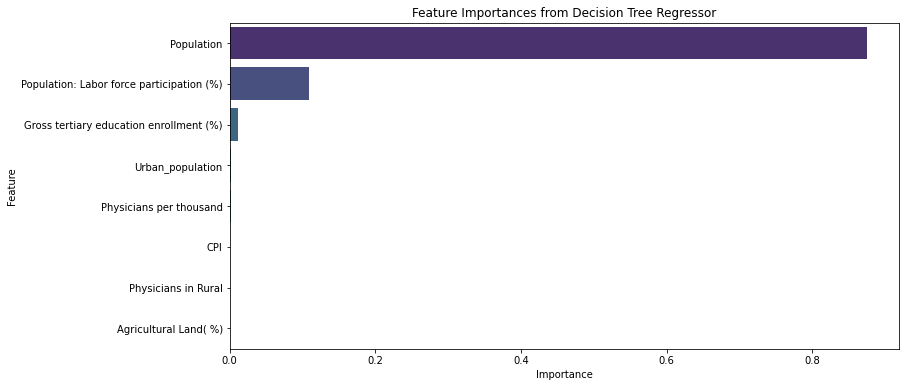

developing dataset:
Feature Importances:
Urban_population: 0.5321308861219793
Gross tertiary education enrollment (%): 0.2539649465242148
Agricultural Land( %): 0.07752440171401163
Physicians per thousand: 0.05951531573565669
CPI: 0.02587447470801131
Population: 0.02539599072806382
Population: Labor force participation (%): 0.024827602452867182
Physicians in Rural: 0.0007663820151952436


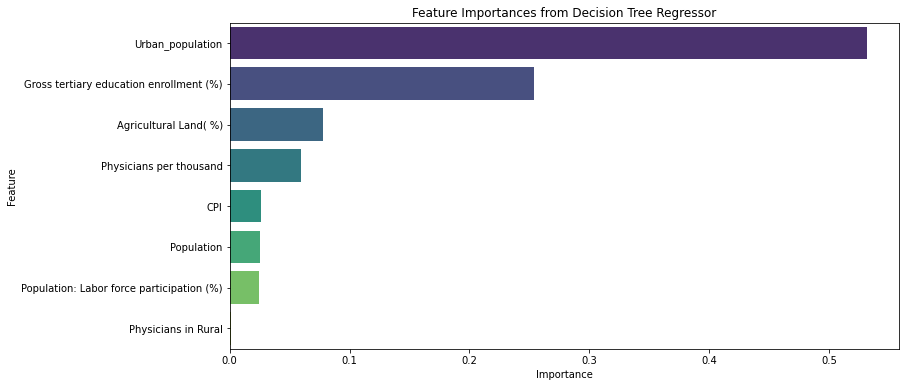

In [20]:
from pyspark.ml.regression import DecisionTreeRegressor
import json

# C&R Tree Algorithm
def CR_Tree(df_spark, max_depth):
    features = df_spark.columns
    features.remove("Country")
    features.remove("Is_Developed")
    features.remove("GDP")
    
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    df_spark = assembler.transform(df_spark)
    
    train_df, test_df = df_spark.randomSplit([0.7, 0.3], seed=42)
    
    # build model
    dtr = DecisionTreeRegressor(featuresCol="features", labelCol="GDP", maxDepth=max_depth)
    model = dtr.fit(train_df)
    
    # get feature importances
    feature_importances = model.featureImportances
    features_df = pd.DataFrame(list(zip(features, feature_importances)), columns=["Feature", "Importance"])
    features_df = features_df.sort_values(by="Importance", ascending=False)
    
    print("Feature Importances:")
    for index, row in features_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']}")
    
#     # evaluator model
#     predictions = model.transform(test_df)
#     evaluator = RegressionEvaluator(labelCol="GDP", predictionCol="prediction", metricName="rmse")
#     rmse = evaluator.evaluate(predictions)
#     r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
#     print(f"\nRoot Mean Squared Error (RMSE): {rmse}")
#     print(f"R² Score: {r2}")
    
    # get plot about importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=features_df, x="Importance", y="Feature", palette="viridis")
    plt.title('Feature Importances from Decision Tree Regressor')
    plt.show()
    
    return model

print("developed dataset:")
model_developed = CR_Tree(developed_df_spark, max_depth=5)
print("developing dataset:")
model_developing = CR_Tree(developing_df_spark, max_depth=5)

In [21]:
# replace feature indices with feature names in the tree structure
def replace_feature_indices(tree_string, feature_names):
    for i, feature in enumerate(feature_names):
        tree_string = tree_string.replace(f"feature {i}", feature)
    return tree_string

# Print tree model with feature names
def print_tree_model(model, feature_names):
    tree_string = model.toDebugString
    tree_string_with_names = replace_feature_indices(tree_string, feature_names)
    print(tree_string_with_names)
    
print("developed dataset tree structure:")
print_tree_model(model_developed, [col for col in developed_df_spark.columns if col not in ["Country", "Is_Developed", "GDP"]])

print("developing dataset tree structure:")
print_tree_model(model_developing, [col for col in developed_df_spark.columns if col not in ["Country", "Is_Developed", "GDP"]])

developed dataset tree structure:
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_dbade0c7920a, depth=5, numNodes=25, numFeatures=8
  If (Population <= 4537284.5)
   If (Population <= 994965.5)
    If (Gross tertiary education enrollment (%) <= 0.495)
     Predict: 6.552858739E9
    Else (Gross tertiary education enrollment (%) > 0.495)
     Predict: 3.154057987E9
   Else (Population > 994965.5)
    If (Gross tertiary education enrollment (%) <= 0.796)
     If (Gross tertiary education enrollment (%) <= 0.7285)
      Predict: 6.0415553039E10
     Else (Gross tertiary education enrollment (%) > 0.7285)
      Predict: 5.3742159517E10
    Else (Gross tertiary education enrollment (%) > 0.796)
     Predict: 3.4117202555E10
  Else (Population > 4537284.5)
   If (Population: Labor force participation (%) <= 0.6065)
    If (Physicians per thousand <= 3.91)
     Predict: 2.68761201365E11
    Else (Physicians per thousand > 3.91)
     If (Gross tertiary education enrollment (%) <= 0.64)


# Iteration 1: Remove GDP from K-Means Cluster

     features.remove("GDP")

# Iteration 2: delete evalution of C&R Tree.

    evaluator model
    predictions = model.transform(test_df)
    evaluator = RegressionEvaluator(labelCol="GDP", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
    print(f"\nRoot Mean Squared Error (RMSE): {rmse}")
    print(f"R² Score: {r2}")
    
# Iteration 3: Change the parameters of the C&R Tree ===> C&R Boosting Tree


C&R Boosting Tree for Developed Countries:


24/05/21 05:26:42 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 14 (= number of training instances)


Feature Importances:
Population: 0.8301094788077258
Population: Labor force participation (%): 0.10708944795684529
CPI: 0.025755608555293755
Gross tertiary education enrollment (%): 0.0181453322067547
Physicians per thousand: 0.008972486344266494
Physicians in Rural: 0.005361000872937971
Agricultural Land( %): 0.0035341063893773003
Urban_population: 0.0010325388667987512


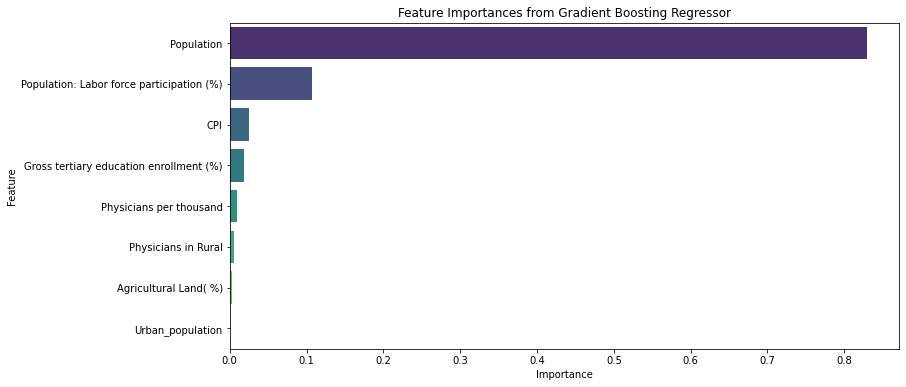

C&R Boosting Tree for Developing Countries:
Feature Importances:
Urban_population: 0.29344102792847093
Gross tertiary education enrollment (%): 0.2095103091439371
Agricultural Land( %): 0.14864716496711514
Physicians per thousand: 0.1137403356243341
CPI: 0.07089827780947544
Physicians in Rural: 0.067624689101092
Population: Labor force participation (%): 0.05166882281559724
Population: 0.044469372609978075


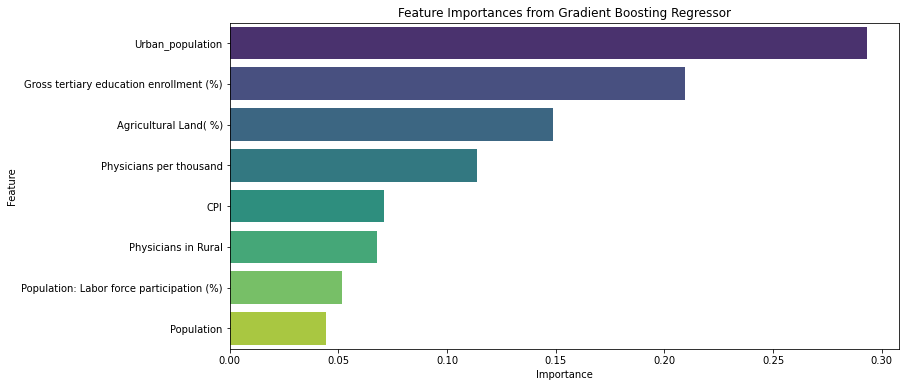

In [24]:
from pyspark.ml.regression import GBTRegressor

def plot_feature_importances(model, feature_names):
    importances = model.featureImportances
    indices = list(range(len(feature_names)))
    features_df = pd.DataFrame(list(zip(feature_names, importances)), columns=["Feature", "Importance"])
    features_df = features_df.sort_values(by="Importance", ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=features_df, x="Importance", y="Feature", palette="viridis")
    plt.title('Feature Importances from Gradient Boosting Regressor')
    plt.show()

# Boosting Tree Algorithm
def CR_Boosting(df_spark, max_depth, max_iter):
    features = df_spark.columns
    features.remove("Country")
    features.remove("Is_Developed")
    features.remove("GDP")
    
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    df_spark = assembler.transform(df_spark)
    
    train_df, test_df = df_spark.randomSplit([0.7, 0.3], seed=42)
    
    # Build model
    gbt = GBTRegressor(featuresCol="features", labelCol="GDP", maxDepth=max_depth, maxIter=max_iter)
    model = gbt.fit(train_df)
    
    # Get feature importances
    feature_importances = model.featureImportances
    features_df = pd.DataFrame(list(zip(features, feature_importances)), columns=["Feature", "Importance"])
    features_df = features_df.sort_values(by="Importance", ascending=False)
    
    print("Feature Importances:")
    for index, row in features_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']}")
    
    # Plot feature importances
    plot_feature_importances(model, features)
    
    return model

print("C&R Boosting Tree for Developed Countries:")
model_developed = CR_Boosting(developed_df_spark, 3, 100)
print("C&R Boosting Tree for Developing Countries:")
model_developing = CR_Boosting(developing_df_spark, 3, 100)
